<a href="https://colab.research.google.com/github/TariqAlhathloul/Time-Series-Forecasting-Project/blob/main/WorkSpace/traffic_Counts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Description: This dataset includes real-time and historical traffic congestion data from Chicago, including traffic flow, speed, and incident reports. It's valuable for studying traffic patterns in urban environments.

## Dataset Overview

#### 1. `ID`: A unique identifier for each traffic count record.

#### 2. `Traffic Volume Count Location Address`: The address where the traffic volume was recorded.

#### 3. `Street`: The street name where the traffic count was taken.

#### 4. `Date of Count`: The date on which the traffic count was recorded.

#### 5. `Total Passing Vehicle Volume`: The total number of vehicles that passed the location during the count period.

#### 6. ` Vehicle Volume By Each Direction of Traffic`: The vehicle count divided by direction (e.g., East Bound, West Bound).

#### 7. `Latitude`: The latitude coordinate of the traffic count location.

#### 8. `Longitude`: The longitude coordinate of the traffic count location.

#### 9. `Location`: The geographic location as a tuple of latitude and longitude.

Check out the [City of Chicago Traffic Data](https://www.chicago.gov/city/en/depts/cdot/dataset/average_daily_trafficcounts.html) for more information.


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repository/blob/main/notebook.ipynb)

## Import Necessary Libraries.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(2024)
tf.random.set_seed(2024)

## Load The Data.

In [ ]:
df_traffic = pd.read_csv("/content/Average_Daily_Traffic_Counts_-_2006.csv")

### Change the datatype of the `Date of Count` from object to datetime.
### drop`ID` and `Location`.
### Set new column `Date` as index.
### sort the values in the dataframe based on the `date`.

In [ ]:
df_traffic['Date'] = pd.to_datetime(df_traffic['Date of Count'], format='%m/%d/%Y')
df_traffic.drop(columns=['ID ', 'Location'], axis=1, inplace=True)
df_traffic.set_index('Date', inplace=True)
df_traffic = df_traffic.sort_values(by='Date')
df = df_traffic.copy()


## Shape Of The Data.

In [ ]:
df_traffic.shape

(1279, 7)

## Head values.

In [ ]:
df_traffic.head().T

Date,2006-02-01,2006-02-01,2006-02-28,2006-02-28,2006-02-28
Traffic Volume Count Location Address,6820 South,5325 South,758 West,7718 South,1275 West
Street,Cottage Grove Ave,Cottage Grove Ave,71st Street,Dr Martin Luther King Jr Dr,71st Street
Date of Count,02/01/2006,02/01/2006,02/28/2006,02/28/2006,02/28/2006
Total Passing Vehicle Volume,21700,13700,21600,16700,16500
Vehicle Volume By Each Direction of Traffic,North Bound: 10300 / South Bound: 11400,North Bound: 7200 / South Bound: 6500,East Bound: 10400 / West Bound: 11200,North Bound: 7900 / South Bound: 8800,East Bound: 7800 / West Bound: 8700
Latitude,41.770685,41.797881,41.765204,41.754187,41.765008
Longitude,-87.605711,-87.606302,-87.644371,-87.615027,-87.657067


## Summary statistics of the numerical attributes.

In [ ]:
df_traffic.describe()

,Total Passing Vehicle Volume,Latitude,Longitude
count,1279.000000,1279.000000,1279.000000
mean,19466.301798,41.849394,-87.670298
std,12448.378467,0.083917,0.060891
min,700.000000,41.651861,-87.854842
25%,11350.000000,41.780249,-87.710013
50%,17300.000000,41.871380,-87.662850
75%,24200.000000,41.909196,-87.628631
max,165200.000000,42.017888,-87.529702


## Summary statistics of the categorical attributes.

In [ ]:
df_traffic.describe(include='O')

,Traffic Volume Count Location Address,Street,Date of Count,Vehicle Volume By Each Direction of Traffic
count,1279,1279,1279,1279
unique,1203,251,95,1223
top,210 South,Damen Ave,03/28/2006,North Bound: 6300 / South Bound: 6200
freq,4,33,73,4


## Information about the dataset.

In [ ]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1279 entries, 2006-02-01 to 2007-06-19
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Traffic Volume Count Location  Address       1279 non-null   object 
 1   Street                                       1279 non-null   object 
 2   Date of Count                                1279 non-null   object 
 3   Total Passing Vehicle Volume                 1279 non-null   int64  
 4   Vehicle Volume By Each Direction of Traffic  1279 non-null   object 
 5   Latitude                                     1279 non-null   float64
 6   Longitude                                    1279 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 79.9+ KB


## Ploting

### Total Traffic Vehicle Volume Of All Time.

#### store the 'Total Passing Vehicle Volume' column in a numpy array


In [ ]:
traffic_volume = df_traffic[['Total Passing Vehicle Volume']]

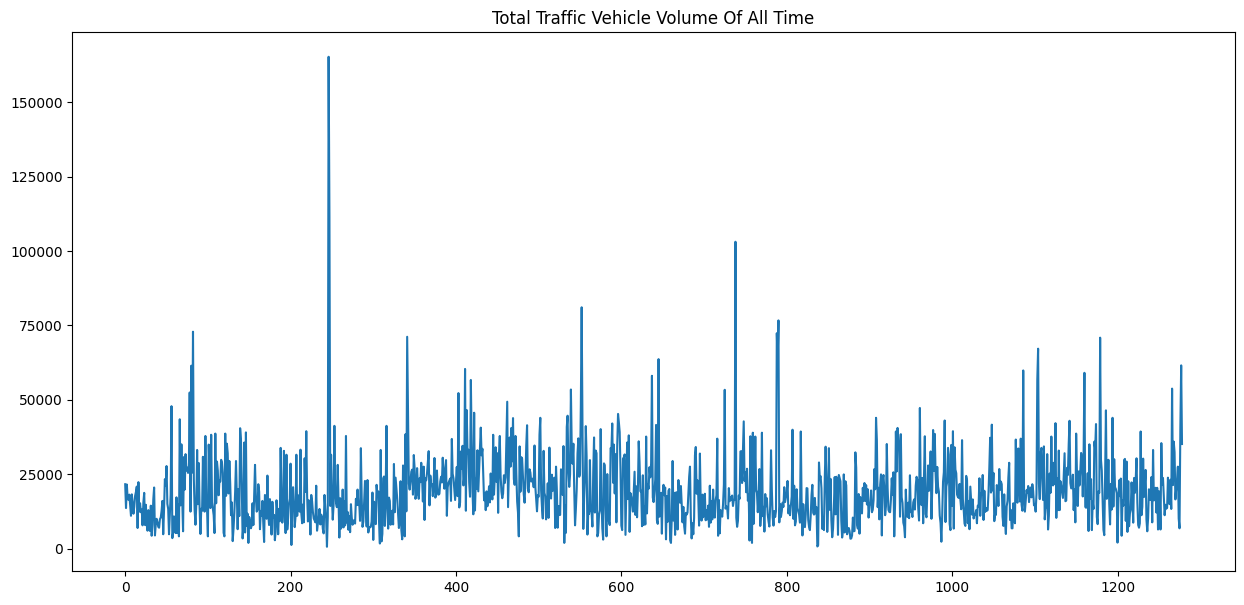

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(traffic_volume.values)
plt.title("Total Traffic Vehicle Volume Of All Time")
plt.show()

### Total Traffic Vehicle Volume Of The First 100 Days In The DataSet.

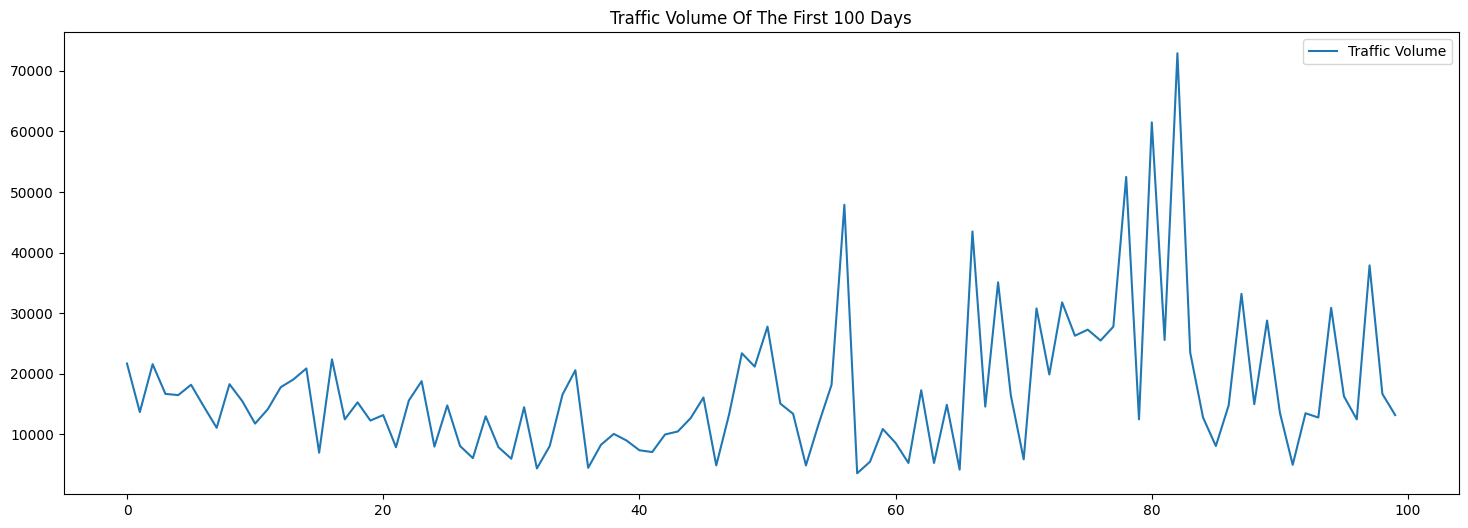

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(traffic_volume[ :100].values)
plt.title("Traffic Volume Of The First 100 Days")
plt.legend(['Traffic Volume'])

## Apply ETS, (Error Trend Seasonality ).

In [ ]:
result = seasonal_decompose(df_traffic['Total Passing Vehicle Volume'], model='additive', period=7)

### plot the result.

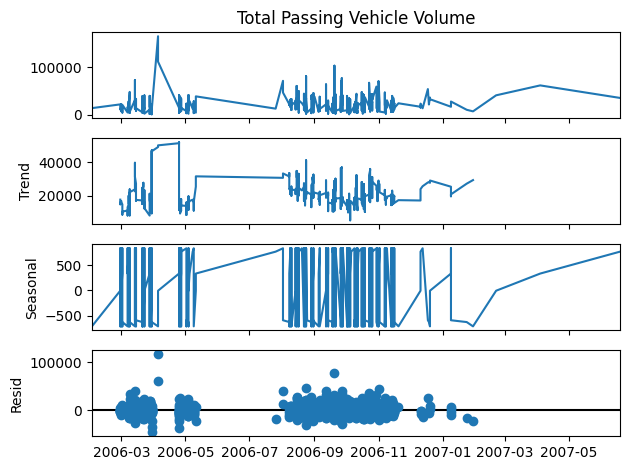

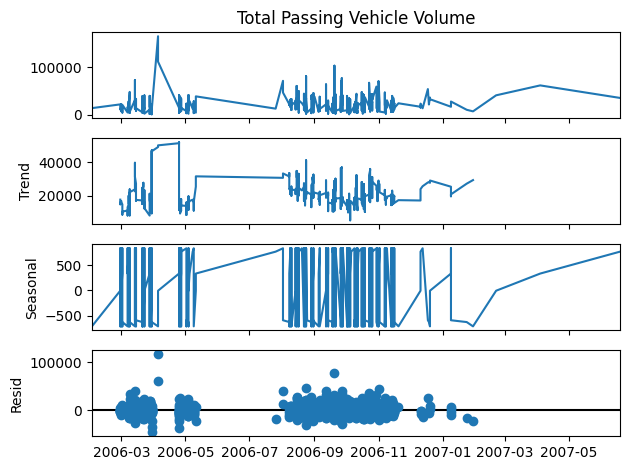

In [ ]:
result.plot()

## Data visualization.

### Data visualization for the Latitude and Longitude.

In [ ]:
fig = px.scatter_mapbox(df_traffic, lat="Latitude", lon="Longitude", color="Total Passing Vehicle Volume",
                            hover_name="Date of Count", hover_data=["Total Passing Vehicle Volume"],
                            color_continuous_scale=px.colors.cyclical.IceFire, zoom=10)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

<Axes: xlabel='Longitude', ylabel='Latitude'>

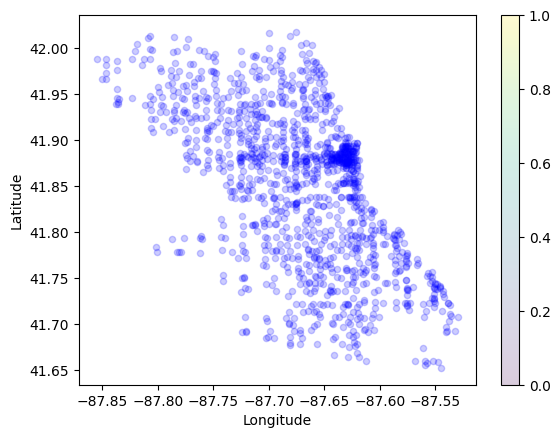

In [ ]:
df_traffic.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.2,c='blue', colorbar=True)

## Top 10 Streets with traffic jams.

<Axes: title={'center': 'Top 10 Streets with traffic jams.'}, xlabel='Street'>

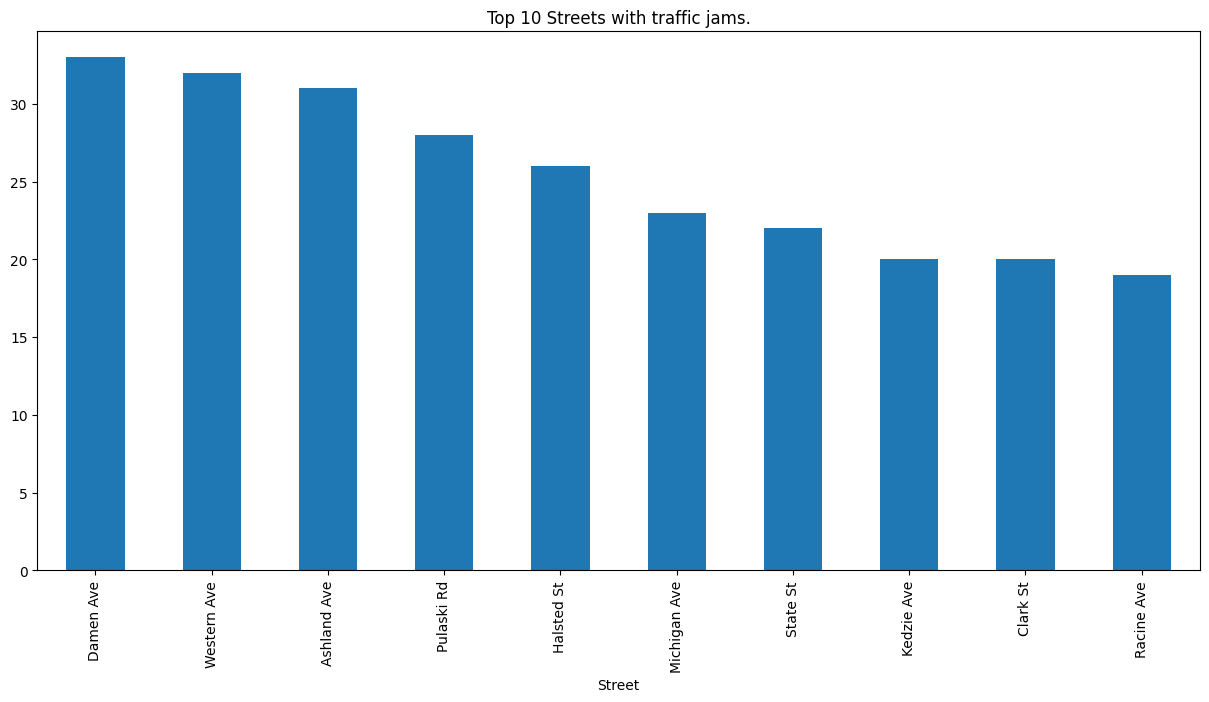

In [ ]:
df_traffic['Street'].value_counts().head(10).plot(kind='bar', figsize=(15, 7), title='Top 10 Streets with traffic jams.')

## Data Preprocessing.

## Check for Missing Values.

In [ ]:
df_traffic.isnull().sum()

,0
Traffic Volume Count Location Address,0
Street,0
Date of Count,0
Total Passing Vehicle Volume,0
Vehicle Volume By Each Direction of Traffic,0
Latitude,0
Longitude,0


## Check for duplicated values.

In [ ]:
df_traffic.duplicated().sum()

0

## Preparing the data for training.

### we will start by normalizing the data.

In [ ]:
## before scaling
traffic_volume[:10]

,Total Passing Vehicle Volume
Date,
2006-02-01,21700
2006-02-01,13700
2006-02-28,21600
2006-02-28,16700
2006-02-28,16500
2006-02-28,18200
2006-02-28,14600
2006-02-28,11100
2006-02-28,18300


## scale the traffic_volume data.

In [ ]:
min_max = MinMaxScaler(feature_range=(0, 1))
traffic_volume = min_max.fit_transform(traffic_volume)

In [ ]:
# after scaling
traffic_volume[:10]

array([[0.12765957],
       [0.07902736],
       [0.12705167],
       [0.09726444],
       [0.09604863],
       [0.10638298],
       [0.08449848],
       [0.06322188],
       [0.10699088],
       [0.0899696 ]])

In [ ]:
traffic_volume.dtype

dtype('float64')

## Data Splitting
### 50% Train, 25% Validation, 25% Test

In [ ]:
train_samples = int(0.5 * len(traffic_volume))
val_samples = int(0.25 * len(traffic_volume))
test_samples = len(traffic_volume) - train_samples - val_samples

In [ ]:
print(f"Train samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: {test_samples}")

Train samples: 639
Validation samples: 319
Test samples: 321


In [ ]:
train, val, test = traffic_volume[0: train_samples, :], traffic_volume[train_samples: train_samples + val_samples, :], traffic_volume[train_samples + val_samples: len(traffic_volume), :]

In [ ]:
print(f"Train size: {train.shape}")
print(f"Validation size: {val.shape}")
print(f"Test size: {test.shape}")

Train size: (639, 1)
Validation size: (319, 1)
Test size: (321, 1)


## function to prepare the train and test datasets for modeling


In [ ]:
def create_dataset(dataset, time_step):
  X, Y = [], []
  for i in range(len(dataset) - time_step -1):
    a = dataset[i: (i + time_step), 0]
    X.append(a)
    Y.append(dataset[i + time_step, 0])

  return np.array(X), np.array(Y)

In [ ]:
time_step = 7
train_X, trainY = create_dataset(train, time_step)
val_X, val_Y = create_dataset(val, time_step)
test_X, testY = create_dataset(test, time_step)

In [ ]:
print(len(train_X))
print(len(test_X))
print(len(val_X))

631
313
311


In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, time_step)))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='traffic_model1.keras',
        save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,153 (20.13 KB)

 Trainable params: 5,153 (20.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_X, trainY,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/50
79/79 - 2s - 29ms/step - loss: 0.0082 - mae: 0.0627 - val_loss: 0.0051 - val_mae: 0.0518
Epoch 2/50
79/79 - 0s - 5ms/step - loss: 0.0062 - mae: 0.0537 - val_loss: 0.0051 - val_mae: 0.0515
Epoch 3/50
79/79 - 0s - 3ms/step - loss: 0.0062 - mae: 0.0535 - val_loss: 0.0050 - val_mae: 0.0513
Epoch 4/50
79/79 - 0s - 3ms/step - loss: 0.0061 - mae: 0.0533 - val_loss: 0.0050 - val_mae: 0.0511
Epoch 5/50
79/79 - 0s - 3ms/step - loss: 0.0061 - mae: 0.0532 - val_loss: 0.0050 - val_mae: 0.0509
Epoch 6/50
79/79 - 0s - 4ms/step - loss: 0.0061 - mae: 0.0531 - val_loss: 0.0050 - val_mae: 0.0508
Epoch 7/50
79/79 - 0s - 3ms/step - loss: 0.0060 - mae: 0.0530 - val_loss: 0.0050 - val_mae: 0.0507
Epoch 8/50
79/79 - 0s - 4ms/step - loss: 0.0060 - mae: 0.0529 - val_loss: 0.0050 - val_mae: 0.0507
Epoch 9/50
79/79 - 0s - 3ms/step - loss: 0.0060 - mae: 0.0529 - val_loss: 0.0050 - val_mae: 0.0506
Epoch 10/50
79/79 - 0s - 3ms/step - loss: 0.0060 - mae: 0.0529 - val_loss: 0.0050 - val_mae: 0.0506
Epoch 11



make predications on X_train and X_test.

In [ ]:
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## let's get the data back to it's original state.

In [ ]:
train_pred = min_max.inverse_transform(train_pred)
trainY_i = min_max.inverse_transform([trainY])

test_pred = min_max.inverse_transform(test_pred)
testY_i = min_max.inverse_transform([testY])

In [ ]:
print(f"trainY shape: {trainY.shape}")
print(f"train_pred shape: {train_pred.shape}")


trainY shape: (631,)
train_pred shape: (631, 1)


In [ ]:

# Calculate RMSE for training data
trainScore = np.sqrt(mean_squared_error(trainY_i[0], train_pred[:, 0]))
print(f"Train Score: {trainScore} RMSE")

# Calculate RMSE for testing data
testScore = np.sqrt(mean_squared_error(testY_i[0], test_pred[:, 0]))
print(f"Test Score: {testScore} RMSE")



Train Score: 12534.483213034644 RMSE
Test Score: 11100.135108178709 RMSE


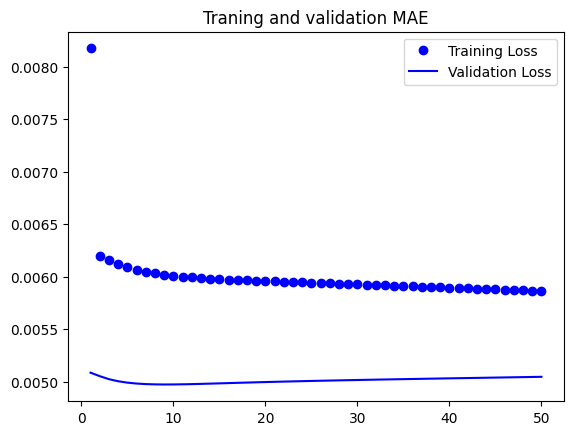

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Traning and validation MAE')
plt.legend()
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

inputs = keras.Input(shape=(1, time_step))

x = keras.layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(1)(x)

model2 = keras.Model(inputs, outputs)

model2.compile(
    optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['mae']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='traffic_model2.keras',
        save_best_only=True
    )
]


history2 = model2.fit(
    train_X, trainY,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/50
79/79 - 2s - 31ms/step - loss: 0.0088 - mae: 0.0658 - val_loss: 0.0049 - val_mae: 0.0497
Epoch 2/50
79/79 - 0s - 3ms/step - loss: 0.0067 - mae: 0.0568 - val_loss: 0.0049 - val_mae: 0.0497
Epoch 3/50
79/79 - 0s - 3ms/step - loss: 0.0070 - mae: 0.0577 - val_loss: 0.0049 - val_mae: 0.0493
Epoch 4/50
79/79 - 0s - 4ms/step - loss: 0.0064 - mae: 0.0553 - val_loss: 0.0049 - val_mae: 0.0501
Epoch 5/50
79/79 - 0s - 4ms/step - loss: 0.0064 - mae: 0.0547 - val_loss: 0.0049 - val_mae: 0.0496
Epoch 6/50
79/79 - 0s - 4ms/step - loss: 0.0067 - mae: 0.0555 - val_loss: 0.0049 - val_mae: 0.0497
Epoch 7/50
79/79 - 0s - 3ms/step - loss: 0.0064 - mae: 0.0551 - val_loss: 0.0049 - val_mae: 0.0499
Epoch 8/50
79/79 - 0s - 4ms/step - loss: 0.0064 - mae: 0.0551 - val_loss: 0.0050 - val_mae: 0.0506
Epoch 9/50
79/79 - 0s - 4ms/step - loss: 0.0064 - mae: 0.0546 - val_loss: 0.0049 - val_mae: 0.0499
Epoch 10/50
79/79 - 0s - 4ms/step - loss: 0.0062 - mae: 0.0543 - val_loss: 0.0049 - val_mae: 0.0494
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


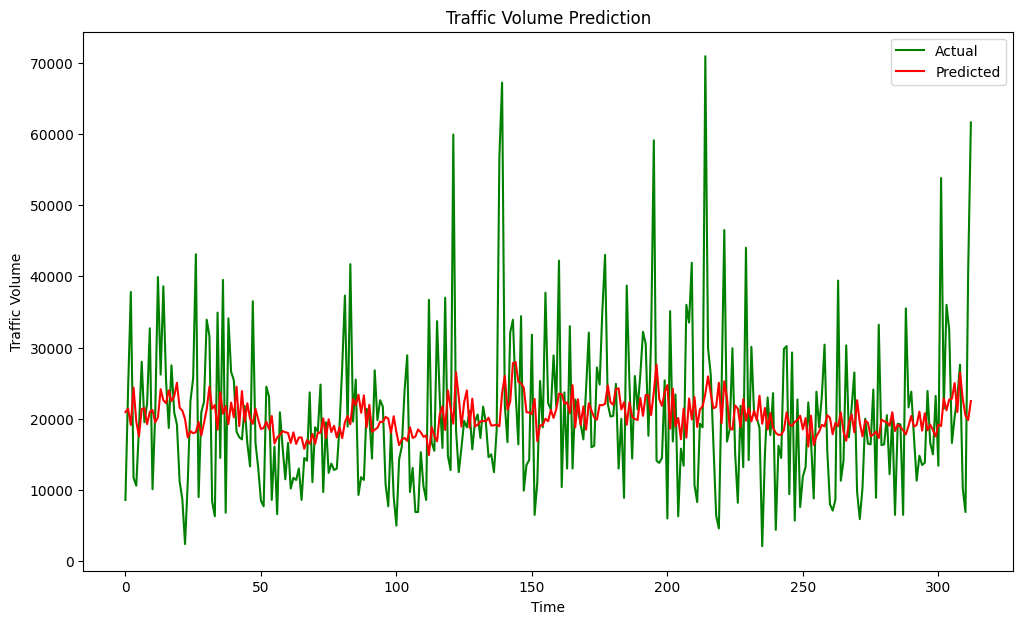

In [ ]:
predictions = model2.predict(test_X)
predictions_rescaled = min_max.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:, 0]
Y_test_rescaled = min_max.inverse_transform(np.concatenate((testY.reshape(-1, 1), np.zeros((testY.shape[0],4))), axis=1))[:, 0]

plt.figure(figsize=(12, 7))
plt.plot(Y_test_rescaled, label='Actual', color='g')
plt.plot(predictions_rescaled, label='Predicted', color='r')
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Prediction")
plt.legend()
plt.show()

In [ ]:
history2.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

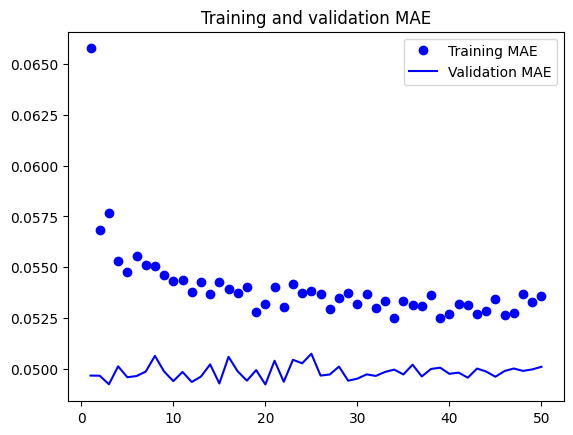

In [ ]:
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

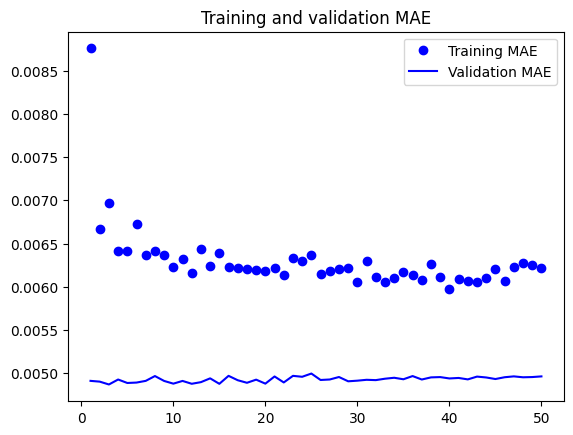

In [ ]:
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# GRU

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1279 entries, 2006-02-01 to 2007-06-19
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Traffic Volume Count Location  Address       1279 non-null   object 
 1   Street                                       1279 non-null   object 
 2   Date of Count                                1279 non-null   object 
 3   Total Passing Vehicle Volume                 1279 non-null   int64  
 4   Vehicle Volume By Each Direction of Traffic  1279 non-null   object 
 5   Latitude                                     1279 non-null   float64
 6   Longitude                                    1279 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 79.9+ KB


In [ ]:
volume_count = df[['Total Passing Vehicle Volume']]

In [ ]:
volume_count.head()

,Total Passing Vehicle Volume
Date,
2006-02-01,21700
2006-02-01,13700
2006-02-28,21600
2006-02-28,16700
2006-02-28,16500


## Preprocessing the data.

In [ ]:
min_max = MinMaxScaler(feature_range=(0, 1))
volume_count_scaled = min_max.fit_transform(volume_count)

In [ ]:
# we will create a sequence of 30 days.

In [ ]:
def create_sequences(data, sequence_len):
  X, Y = [], []

  for i in range(sequence_len, len(data)):
    X.append(data[i - sequence_len: i, 0])
    Y.append(data[i, 0])

  return np.array(X), np.array(Y)

In [ ]:
seq_len = 30

x, y = create_sequences(volume_count_scaled, seq_len)

In [ ]:
y[1]

0.08389057750759878

In [ ]:
x[1]

array([0.07902736, 0.12705167, 0.09726444, 0.09604863, 0.10638298,
       0.08449848, 0.06322188, 0.10699088, 0.0899696 , 0.0674772 ,
       0.08206687, 0.10395137, 0.1118541 , 0.12279635, 0.03829787,
       0.13191489, 0.07173252, 0.0887538 , 0.07051672, 0.07598784,
       0.043769  , 0.09057751, 0.1100304 , 0.0443769 , 0.08571429,
       0.0449848 , 0.03282675, 0.07477204, 0.043769  , 0.03221884])

In [ ]:
train_size = int(0.5 * len(x))
val_size = int(0.25 * len(x))
test_size = len(x) - train_size - val_size

X_TRAIN = x[:train_size]
X_VAL = x[train_size:train_size + val_size]
X_TEST = x[train_size + val_size:]

Y_TRAIN = y[:train_size]
Y_VAL = y[train_size:train_size + val_size]
Y_TEST = y[train_size + val_size:]

In [ ]:
X_TRAIN.shape[1]

30

## Modeling.

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input

model3 = Sequential([
    Input(shape=(X_TRAIN.shape[1],1)),

    GRU(units=32, return_sequences=True),
    Dropout(0.2),
    GRU(units=64, return_sequences=False),
    Dense(units=32),
    Dropout(0.2),
    Dense(units=1)
])

In [ ]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                          │ (None, 30, 32)              │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 64)                  │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,073 (105.75 KB)

 Trainable params: 27,073 (105.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
    )

In [ ]:
call_back = [
    keras.callbacks.EarlyStopping(monitor='mae', patience=10),
    keras.callbacks.ModelCheckpoint('Models/GRU_Model_3.keras', save_best_only=True)
]

In [ ]:
history3 = model3.fit(
    X_TRAIN,
    Y_TRAIN,
    epochs=50,
    validation_data=(X_VAL,Y_VAL),
    callbacks=call_back
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0091 - mae: 0.0612 - val_loss: 0.0049 - val_mae: 0.0500
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0090 - mae: 0.0610 - val_loss: 0.0049 - val_mae: 0.0500
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0090 - mae: 0.0618 - val_loss: 0.0050 - val_mae: 0.0509
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0091 - mae: 0.0626 - val_loss: 0.0049 - val_mae: 0.0494
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0089 - mae: 0.0615 - val_loss: 0.0049 - val_mae: 0.0498
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0089 - mae: 0.0609 - val_loss: 0.0050 - val_mae: 0.0507
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0090 - mae: 0.0611 - val_loss: 0.0049 - val_mae: 0.0499
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0091 - mae: 0.0613 - val_loss: 0.0050 - val_mae: 0.0513
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.00

In [ ]:
predictions = model3.predict(X_TEST)

predictions = min_max.inverse_transform(predictions.reshape(-1,1))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
y_true = min_max.inverse_transform(Y_TEST.reshape(-1, 1))

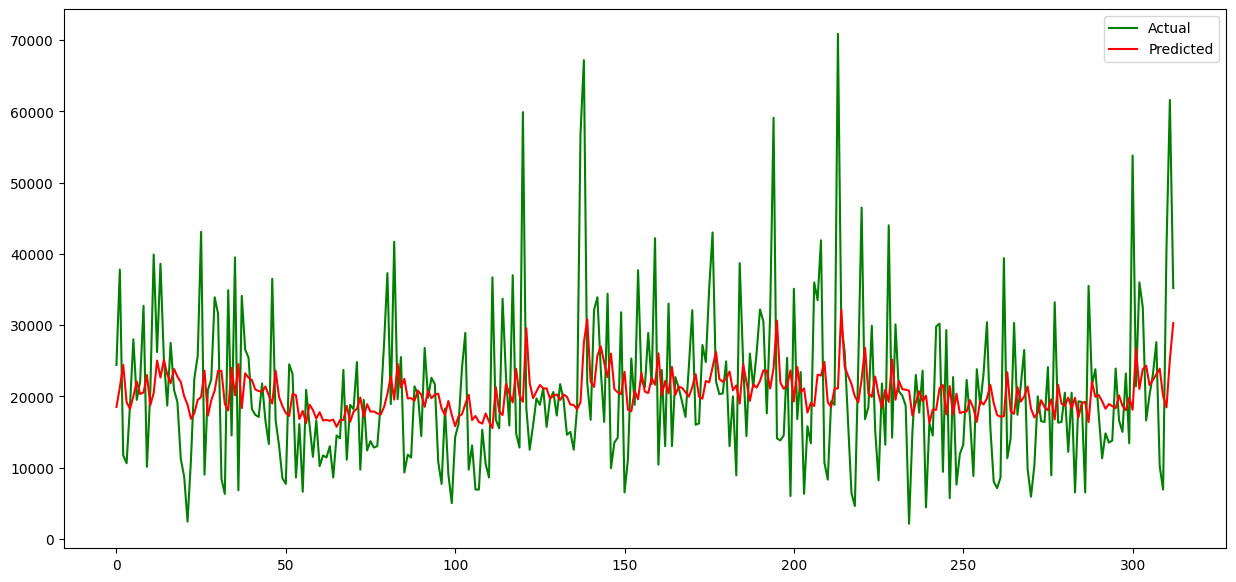

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(y_true, color='green', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.show()